[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Message summarization

Now, let's take it one step further! Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation. This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot. And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [4]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_llm_with_summary(state: State):
    # Get summary if it exists
    summary = state.get("summary", "")
    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"
        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = llm.invoke(messages)

    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [6]:
def summarize_conversation(state: State):
    # First, we get any existing summary
    summary = state.get("summary", "")
    # Create our summarization prompt 
    if summary:
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [7]:
from langgraph.graph import END

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("call_llm_with_summary", call_llm_with_summary)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "call_llm_with_summary")
workflow.add_conditional_edges("call_llm_with_summary", should_continue)
workflow.add_edge("summarize_conversation", END)

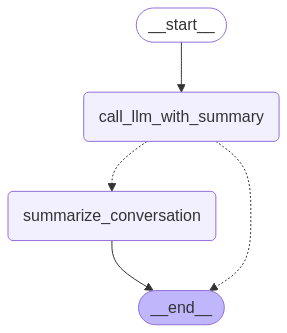

In [9]:
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
state = graph.invoke({"messages": [HumanMessage(content="Hi! I'm Lance")]})
if 'summary' in state:
    print('Summary:', state['summary'])
else:
    print('No summary')
for m in state['messages']:
    m.pretty_print()

No summary
================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you Lance! How can I assist you today?


In [11]:
state['messages'] = state["messages"] + [HumanMessage(content="I'm from France")]
state = graph.invoke(state)
if 'summary' in state:
    print('Summary:', state['summary'])
else:
    print('No summary')
for m in state['messages']:
    m.pretty_print()

No summary
================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you Lance! How can I assist you today?
================================ Human Message =================================

I'm from France
================================== Ai Message ==================================

That's great! How can I help you today?


In [12]:
state['messages'] = state["messages"] + [HumanMessage(content="Make a short poem about me")]
state = graph.invoke(state)
if 'summary' in state:
    print('Summary:', state['summary'])
else:
    print('No summary')
for m in state['messages']:
    m.pretty_print()

Summary: In the conversation above, Lance introduced himself as being from France. He then requested a short poem about himself, to which a poem was created highlighting his strong and true spirit. Lance then asked for a summary of the conversation.
================================ Human Message =================================

Make a short poem about me
================================== Ai Message ==================================

Sure! Here's a short poem for you, Lance:

In France, Lance does reside,
With a spirit that cannot hide.
A name so strong and true,
Bringing light in all he'll do.

I hope you liked it!


## Adding memory

Let's do something to avoid passing state every time and allow agent to persistently accumulate info.
The solution is to use`MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

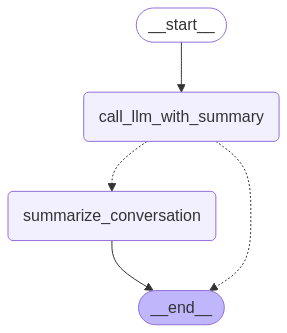

In [13]:
 # Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [14]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="Hi! I'm Lance")
state = graph.invoke({"messages": [input_message]}, config)

if 'summary' in state:
    print('Summary:', state['summary'])
else:
    print('No summary')

for m in state['messages']:
    m.pretty_print()


No summary
================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you Lance! How can I assist you today?


Now, we don't yet have a summary of the state because we still have < = 4 messages.

This was set in `should_continue`.

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [15]:
input_message = HumanMessage(content="What's my name?")
state = graph.invoke({"messages": [input_message]}, config)

if 'summary' in state:
    print('Summary:', state['summary'])
else:
    print('No summary')

for m in state['messages']:
    m.pretty_print()

No summary
================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you Lance! How can I assist you today?
================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

Your name is Lance.


In [16]:
input_message = HumanMessage(content="I like Cyprus!")
state = graph.invoke({"messages": [input_message]}, config)

if 'summary' in state:
    print('Summary:', state['summary'])
else:
    print('No summary')

for m in state['messages']:
    m.pretty_print()

Summary: The conversation involved introducing ourselves, with Lance expressing his liking for Cyprus.
================================ Human Message =================================

I like Cyprus!
================================== Ai Message ==================================

That's great to hear! Cyprus is a beautiful island with a rich history and stunning landscapes. Have you visited Cyprus before or do you have a special connection to the country?


In [17]:
input_message = HumanMessage(content="What is the capital?")
state = graph.invoke({"messages": [input_message]}, config)

if 'summary' in state:
    print('Summary:', state['summary'])
else:
    print('No summary')

for m in state['messages']:
    m.pretty_print()

# Q: If I restart the kernel, the state will reload?

Summary: The conversation involved introducing ourselves, with Lance expressing his liking for Cyprus.
================================ Human Message =================================

I like Cyprus!
================================== Ai Message ==================================

That's great to hear! Cyprus is a beautiful island with a rich history and stunning landscapes. Have you visited Cyprus before or do you have a special connection to the country?
================================ Human Message =================================

What is the capital?
================================== Ai Message ==================================

The capital of Cyprus is Nicosia. It is the largest city on the island and serves as the political, cultural, and economic center of Cyprus. Nicosia is known for its historic city walls, museums, and vibrant street life. Have you ever been to Nicosia or are you planning to visit in the future?


The `config` with thread ID allows us to proceed from the previously logged state!

In [18]:
config

{'configurable': {'thread_id': '2'}}

In [19]:
graph.get_state(config).values.get("summary")

'The conversation involved introducing ourselves, with Lance expressing his liking for Cyprus.'

In [20]:
graph.get_state({'configurable': {'thread_id': '2'}}).values.get("summary", "No summary")

'The conversation involved introducing ourselves, with Lance expressing his liking for Cyprus.'